# Introduction


## **The objective** 
To predict which type of customers would have a risk of being default 

## Datasets and Features
**Default Customer** : if a customer does not pay due amount in 120 days after the latest statement date


# Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
import gc

warnings.filterwarnings("ignore")

# Import Dataset
- parquet file :train_data, test_data
- pickle file: train_labels

In [2]:
%%time
train = pd.read_parquet('train_data.parquet')

Wall time: 8.24 s


In [10]:
%%time
test = pd.read_parquet('test_data.parquet')

ArrowMemoryError: malloc of size 8409183936 failed

In [4]:
%%time
labels = pd.read_csv('train_labels.csv')

Wall time: 406 ms


## Reduce dataset size

*Reference*: 
- https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
- https://pythonsimplified.com/how-to-handle-large-datasets-in-python-with-pandas/

In [5]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**3
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                # np.iinfo : Get information about integer data type
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**3
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 4.10 MB
Memory usage after optimization is: 2.02 MB
Decreased by 50.8%


In [9]:
test = reduce_mem_usage(test)

NameError: name 'test' is not defined

# EDA

## Categorical Features

In [12]:
categorical_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68','target']
date_cols = ['S_2']

<Figure size 2160x1440 with 0 Axes>

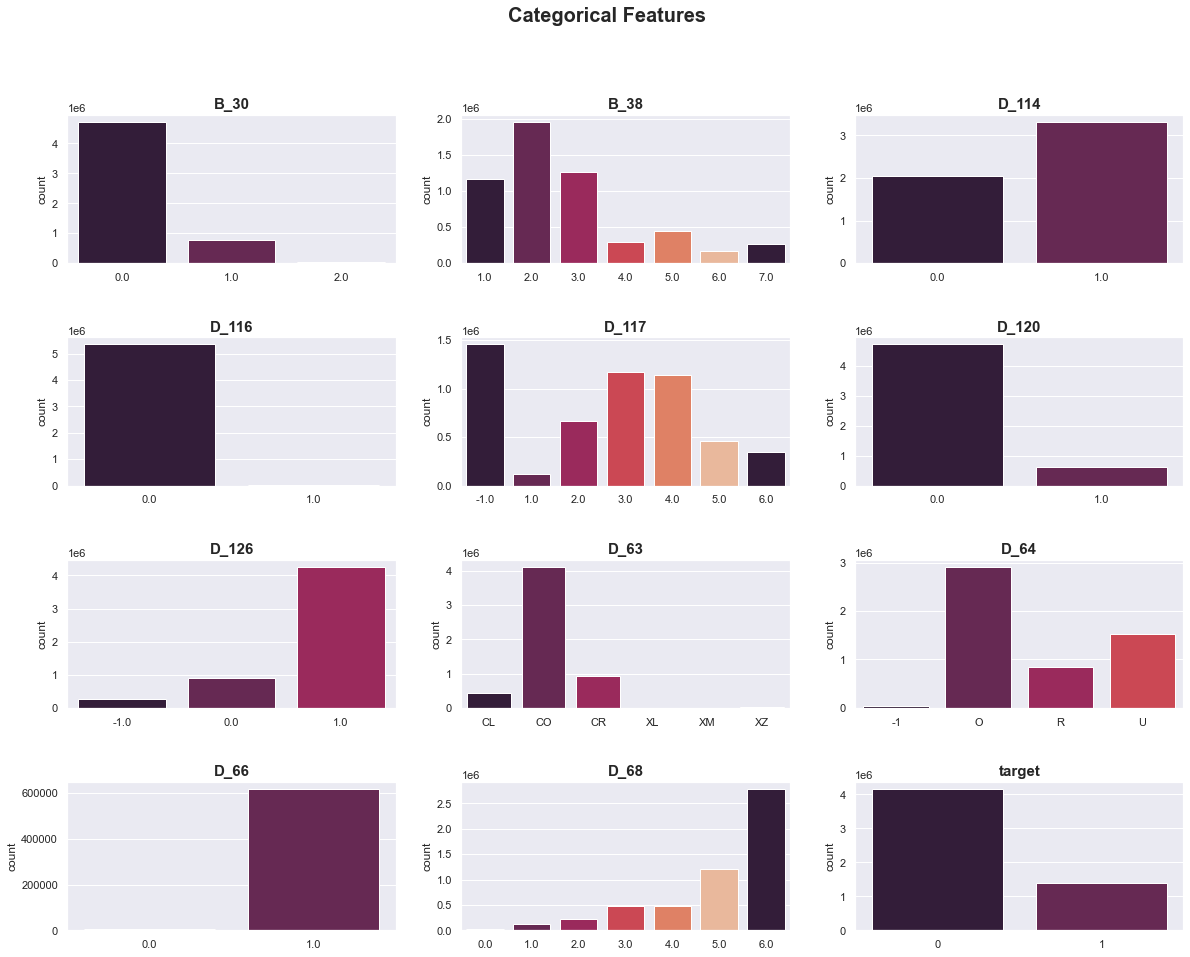

In [13]:
import itertools

plt.figure(figsize = (30,20))
plt.subplots(figsize = (20,15))
# # age_pro = pd.crosstab(pro['Age'], pro['RegroupJobTitle'])
# # age_nonpro = pd.crosstab(nonpro['Age'], nonpro['RegroupJobTitle'])
# category = ['DS','DA','DE','OTHER']
categorical_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68','target']
date_cols = ['S_2']

length = len(categorical_cols)

sns.set_theme(style="darkgrid") 

for i, j in itertools.zip_longest(categorical_cols, range(length)):
    plt.subplot( (length/3), 3, j+1) # nrows, ncols, index
    plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
    palette = sns.color_palette("rocket")
    sns.countplot(data = train, x = i, palette=palette)
    plt.suptitle('Categorical Features', size = 20, weight = 'bold')
    plt.title(i, size = 15, weight = 'bold')
    plt.xlabel('')
plt.show()

As the above shows, there are 3 binary feautres except for target and the most of them contiains more than 2 values. 

## Insights
- Both **D_116** and **D_66** seems to be extremely imbalanced, which can be said they have meaningless information. (Useless)
- Although **D_120** is not as much imbalanced as D_116 and D_66, it needs to be investigated if there is correlated to **target**
- Unlike non-binary features, **B_30** seems to convey binary information
- Some categorical features needs to be redesignated or reduced its dimention since there are not enough information especailly **D_63**, **D_64** and **D_68**

Let's dive into these features deaply!

In [14]:
default_ratio = 100 * round(train['target'].sum()/train.shape[0],4)
print(f'The default customer ratio is {default_ratio}%')

The default customer ratio is 24.91%


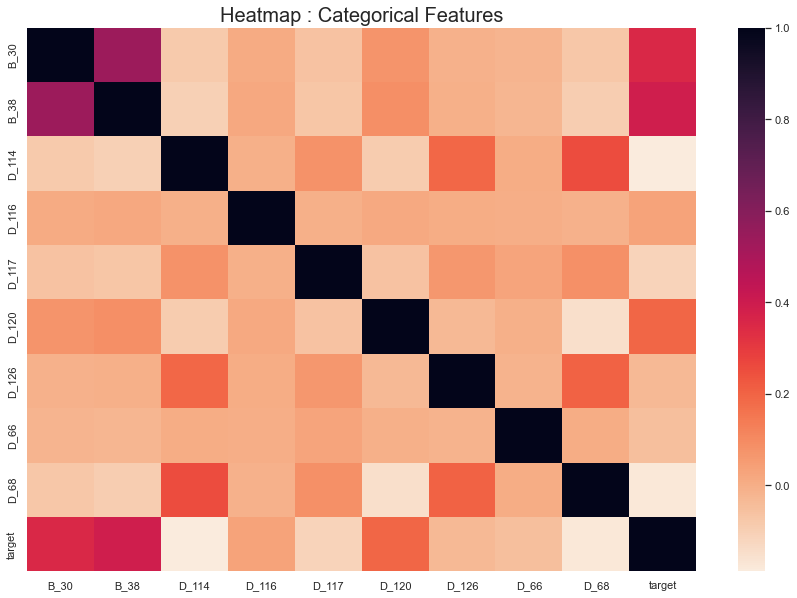

In [15]:
plt.figure(figsize = (15,10))

cmap = sns.color_palette("rocket_r", as_cmap=True)
sns.heatmap(train.loc[:, categorical_cols].corr(), cmap = cmap)

plt.title('Heatmap : Categorical Features', fontdict = {'size': 20})
plt.show()

## Insights
### Correlation to Target
- Strong Relationship
    - **B_30** & **B_38**
- Minimal Relationship 
    - **D_120**

## Numercial Features

D_* = Delinquency variables

S_* = Spend variables

P_* = Payment variables

B_* = Balance variables

R_* = Risk variables

Let's Take a glance at variables

In [16]:
# Take a glance at variables 
"""
1. How many feautures of each varible are there?
2. How many features does it contain missing values?
3. The number of numeric features?
"""
columns_list = train.columns.tolist()
def get_numeric_features_with_missingvalue(columns_list, col_list = [], string_starts_with = 'D'):
    col_list = []
    for col in columns_list:
        if col.startswith(string_starts_with) ==True:
            col_list.append(col)
    # Get Variable Explaination
    variable_explaination = {'D': 'Delinquency', 'S': 'Spend', 'P' : 'Payment', 'B' : 'Balance', 'R': 'Risk'}
    explaination = variable_explaination[string_starts_with]
    print(f'{explaination} variables : {len(col_list)}')

    # How many features there are with missing values
    na_features = (train.loc[:,col_list].isna().sum() > 0).sum()
    print(f'The number of features containing NA values : {na_features}')

    # Get only numerical features
    for cat in categorical_cols:
        if cat.startswith(string_starts_with):
            col_list.remove(cat)
    print(f'The number of numeric {explaination} features are {len(col_list)}')

    return col_list

### 1. Delinquency variables (Starts with "D")

Delinquency variables : 96
The number of features containing NA values : 81
The number of numeric Delinquency features are 87


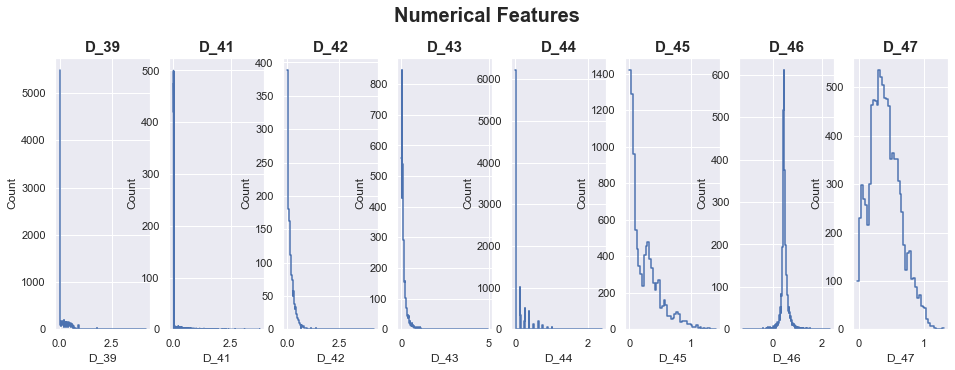

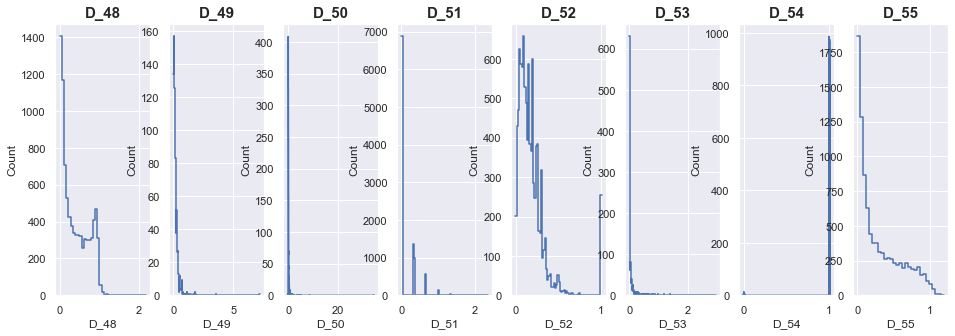

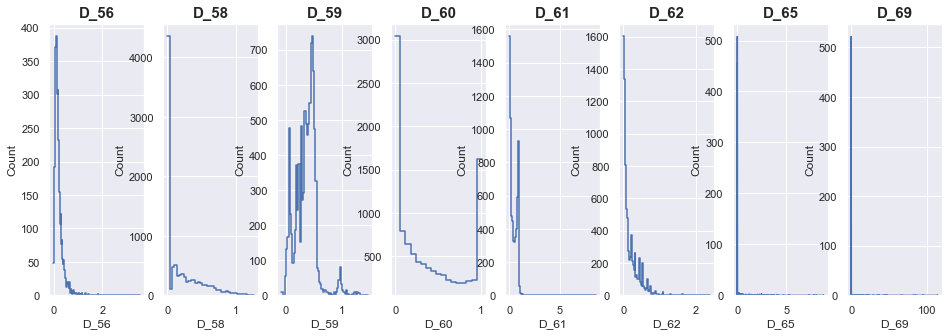

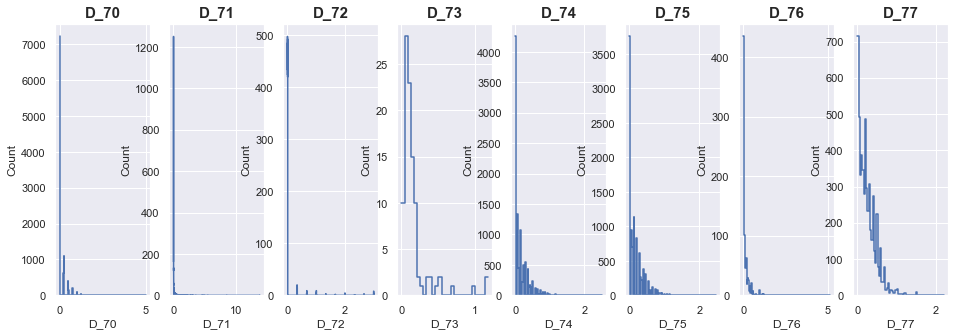

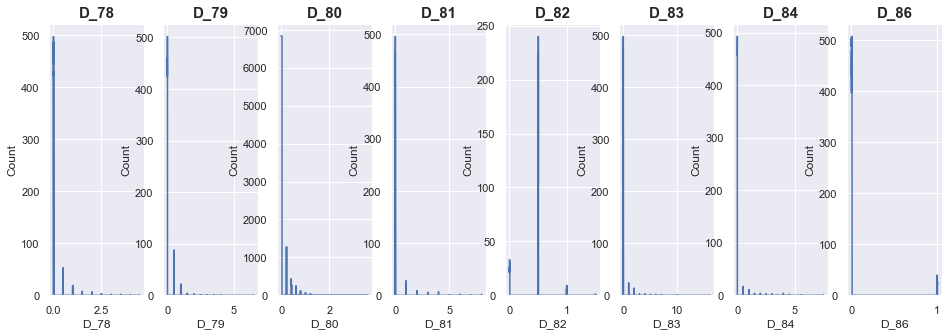

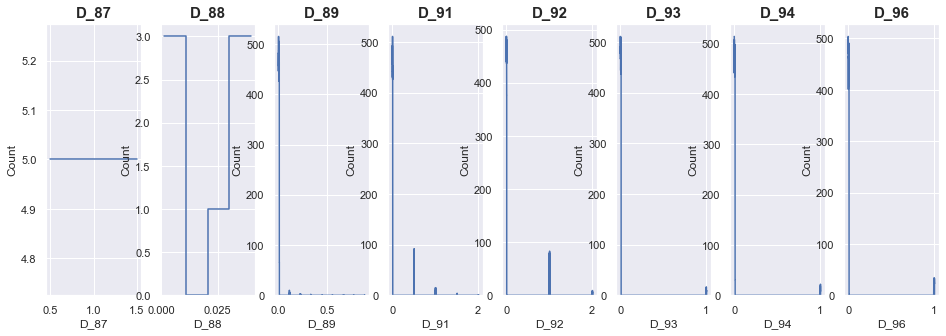

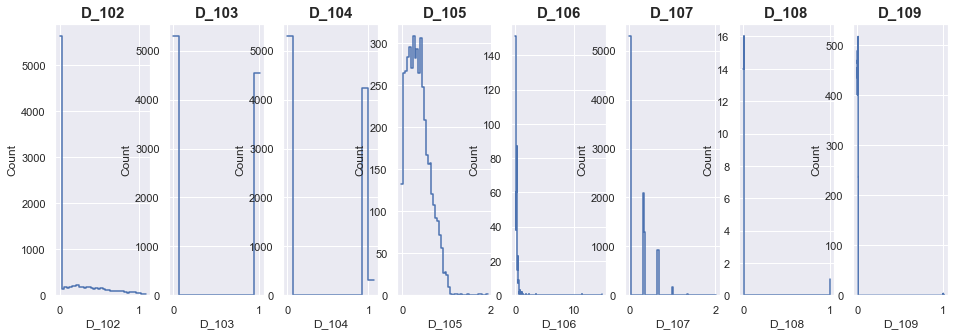

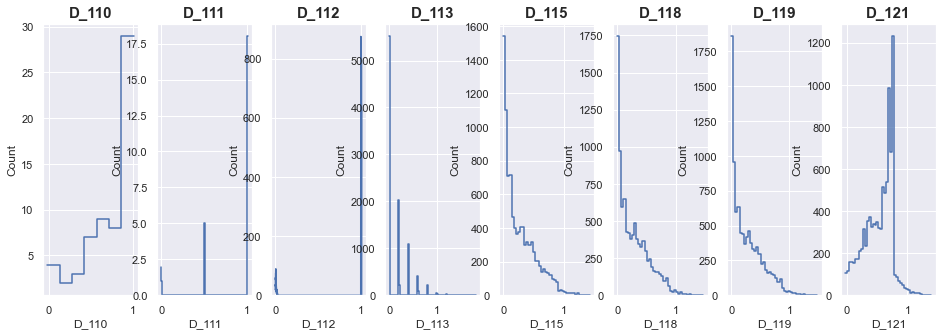

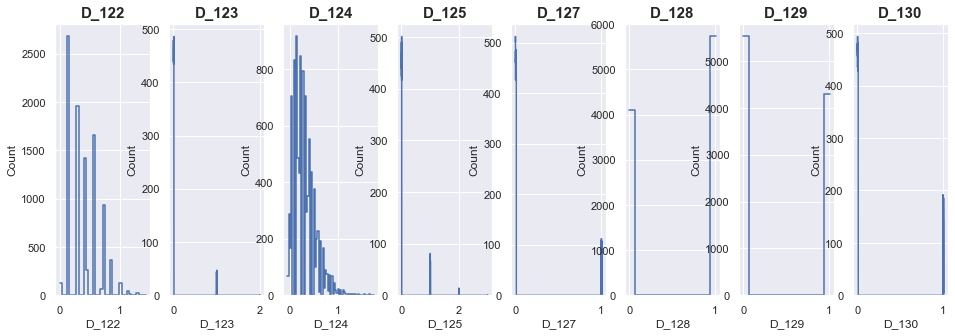

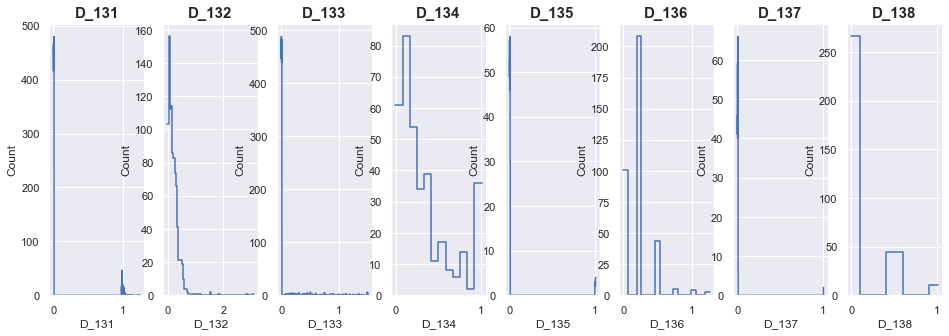

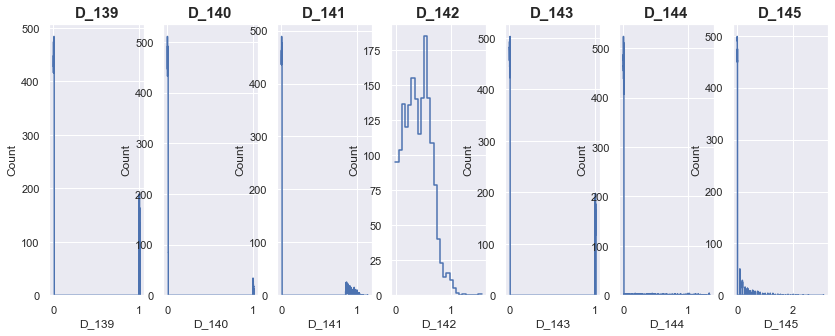

In [22]:
D_col_list = get_numeric_features_with_missingvalue(columns_list=columns_list, col_list = [], string_starts_with = 'D')

import random
random.seed(10)
rand_index = random.sample(range(train.shape[0]), 10000)
ncols = 8

# Extract a part of dataset for visualization randomly
data_random = train.loc[rand_index, :].reset_index(drop = True)

for i, j in enumerate(D_col_list):
    if i % ncols == 0: 
        if i > 0: 
            plt.show()
        plt.figure(figsize=(16, 5))
        if i == 0: 
            plt.suptitle('Numerical Features', fontsize=20, y=1.02, weight = 'bold')
    plt.subplot(1, ncols, i % ncols + 1)
    sns.histplot(data = data_random, x = j, element='step', fill = False) # random index
    plt.title(j, size = 15, weight = 'bold')
    plt.xlabel(j)
plt.show()

### 2. Spend Variables(Starts with "S")

Spend variables : 22
The number of features containing NA values : 9
The number of numeric Spend features are 22


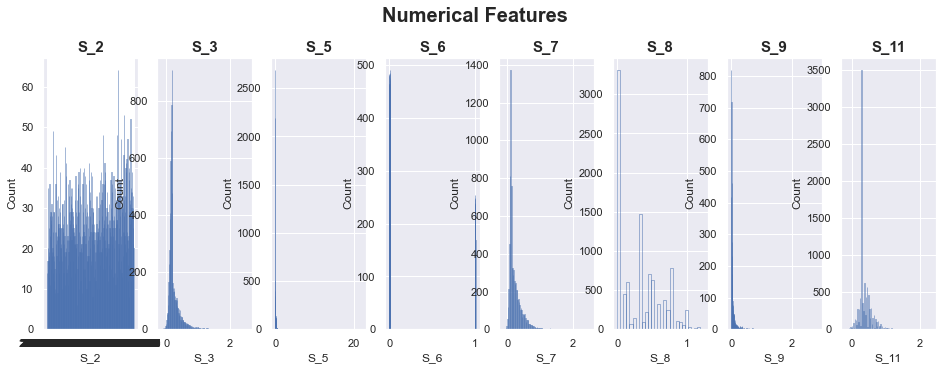

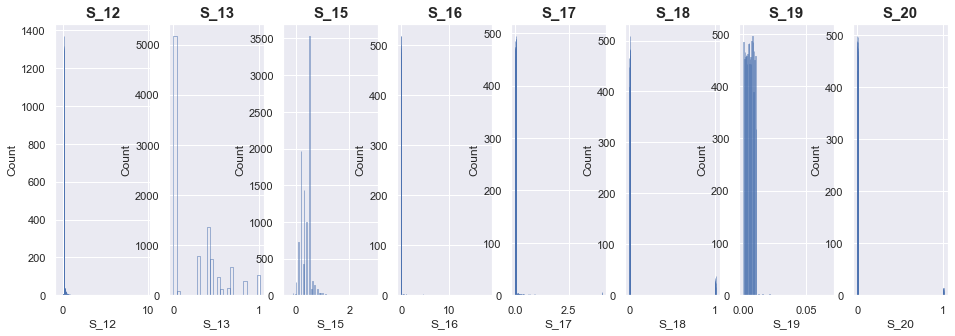

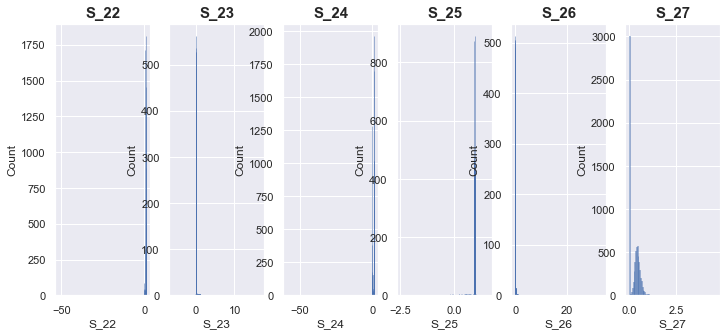

In [28]:
S_col_list = get_numeric_features_with_missingvalue(columns_list=columns_list, col_list = [], string_starts_with = 'S')

import random
random.seed(10)
rand_index = random.sample(range(train.shape[0]), 10000)
ncols = 8

# Extract a part of dataset for visualization randomly
data_random = train.loc[rand_index, :].reset_index(drop = True)

for i, j in enumerate(S_col_list):
    if i % ncols == 0: 
        if i > 0: 
            plt.show()
        plt.figure(figsize=(16, 5))
        if i == 0: 
            plt.suptitle('Numerical Features', fontsize=20, y=1.02, weight = 'bold')
    plt.subplot(1, ncols, i % ncols + 1)
    sns.histplot(data = data_random, x = j, element='bars', fill = False) # random index
    plt.title(j, size = 15, weight = 'bold')
    plt.xlabel(j)
plt.show()

### 3. Payment Variables(Starts with "P")

Payment variables : 3
The number of features containing NA values : 2
The number of numeric Payment features are 3


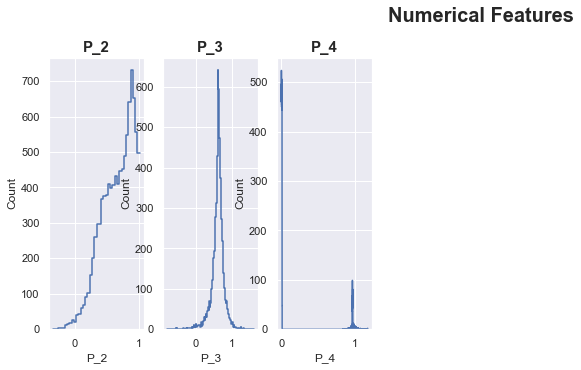

In [25]:
P_col_list = get_numeric_features_with_missingvalue(columns_list=columns_list, col_list = [], string_starts_with = 'P')

import random
random.seed(10)
rand_index = random.sample(range(train.shape[0]), 10000)
ncols = 8

# Extract a part of dataset for visualization randomly
data_random = train.loc[rand_index, :].reset_index(drop = True)

for i, j in enumerate(P_col_list):
    if i % ncols == 0: 
        if i > 0: 
            plt.show()
        plt.figure(figsize=(16, 5))
        if i == 0: 
            plt.suptitle('Numerical Features', fontsize=20, y=1.02, weight = 'bold')
    plt.subplot(1, ncols, i % ncols + 1)
    sns.histplot(data = data_random, x = j, element='step', fill = False) # random index
    plt.title(j, size = 15, weight = 'bold')
    plt.xlabel(j)
plt.show()


### 4. Balance Variables(Starts with "B")

Balance variables : 40
The number of features containing NA values : 23
The number of numeric Balance features are 38


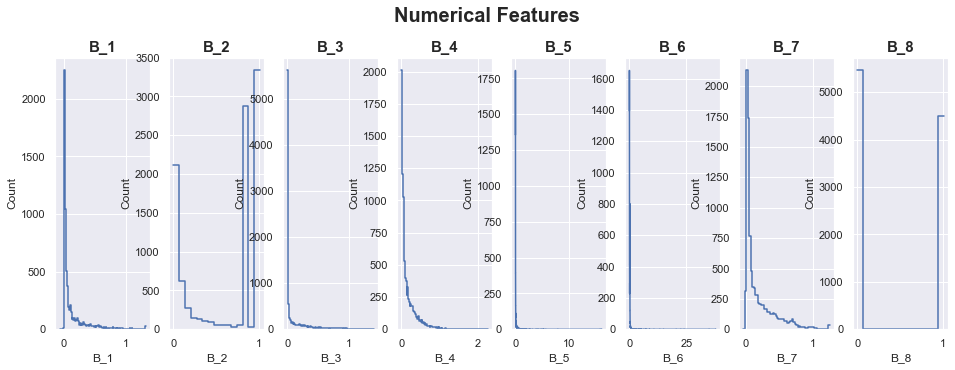

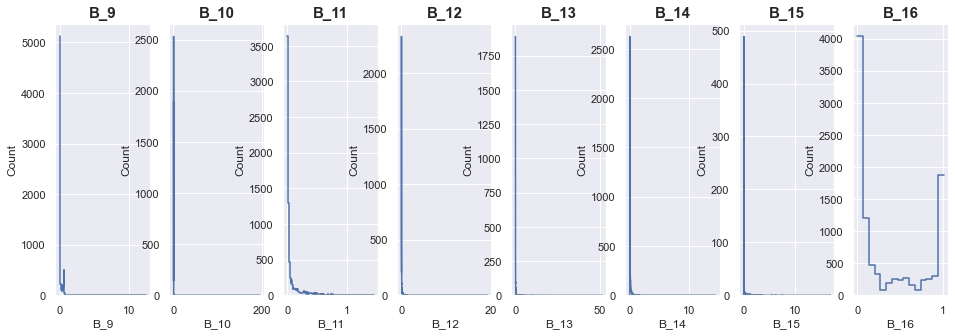

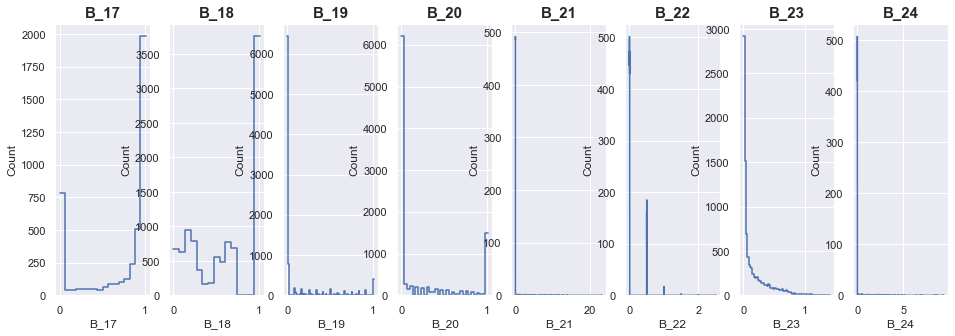

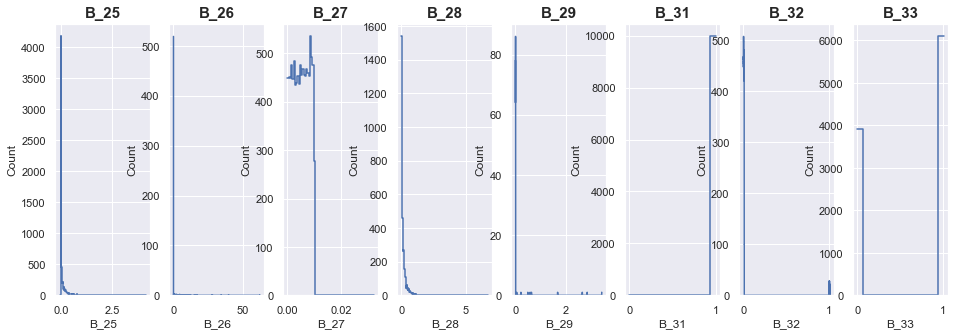

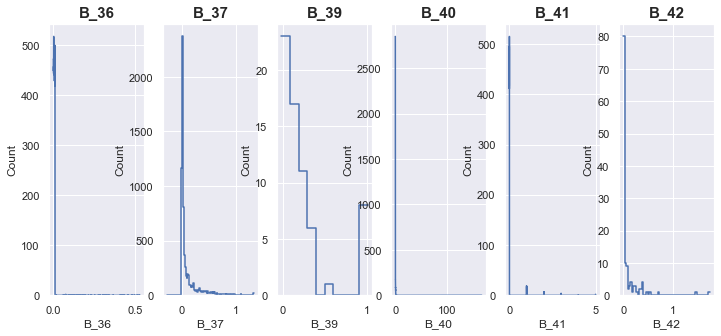

In [26]:
B_col_list = get_numeric_features_with_missingvalue(columns_list=columns_list, col_list = [], string_starts_with = 'B')

import random
random.seed(10)
rand_index = random.sample(range(train.shape[0]), 10000)
ncols = 8

# Extract a part of dataset for visualization randomly
data_random = train.loc[rand_index, :].reset_index(drop = True)

for i, j in enumerate(B_col_list):
    if i % ncols == 0: 
        if i > 0: 
            plt.show()
        plt.figure(figsize=(16, 5))
        if i == 0: 
            plt.suptitle('Numerical Features', fontsize=20, y=1.02, weight = 'bold')
    plt.subplot(1, ncols, i % ncols + 1)
    sns.histplot(data = data_random, x = j, element='step', fill = False) # random index
    plt.title(j, size = 15, weight = 'bold')
    plt.xlabel(j)
plt.show()

### 5. Risk Variables(Starts with "R")

Risk variables : 28
The number of features containing NA values : 7
The number of numeric Risk features are 28


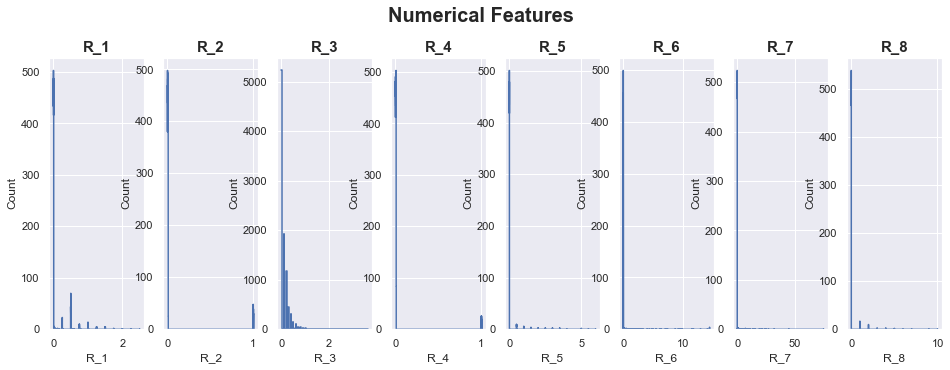

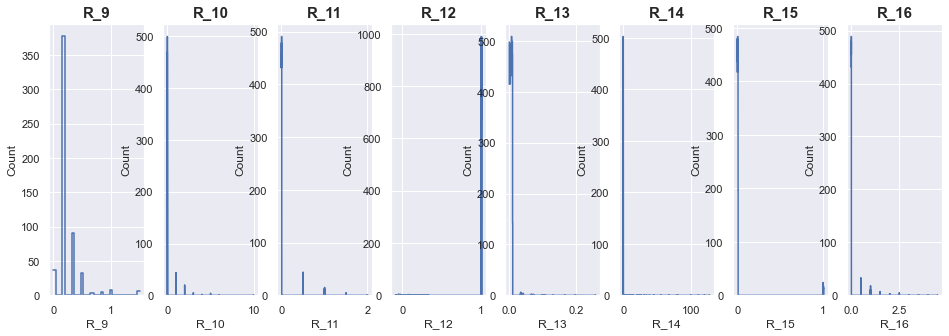

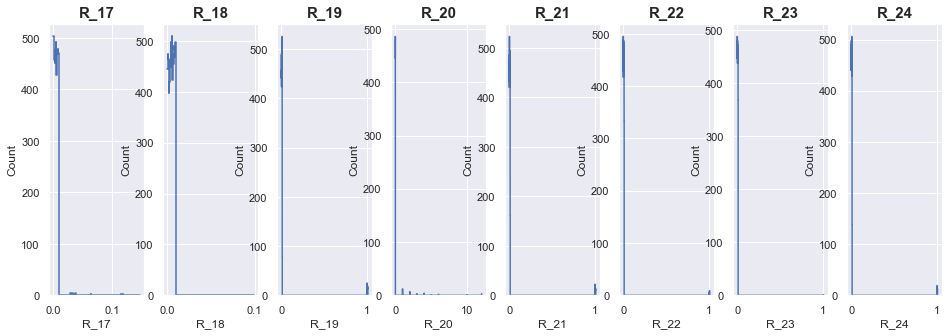

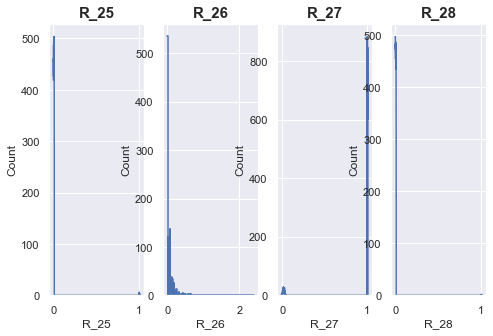

In [27]:
R_col_list = get_numeric_features_with_missingvalue(columns_list=columns_list, col_list = [], string_starts_with = 'R')

import random
random.seed(10)
rand_index = random.sample(range(train.shape[0]), 10000)
ncols = 8

# Extract a part of dataset for visualization randomly
data_random = train.loc[rand_index, :].reset_index(drop = True)

for i, j in enumerate(R_col_list):
    if i % ncols == 0: 
        if i > 0: 
            plt.show()
        plt.figure(figsize=(16, 5))
        if i == 0: 
            plt.suptitle('Numerical Features', fontsize=20, y=1.02, weight = 'bold')
    plt.subplot(1, ncols, i % ncols + 1)
    sns.histplot(data = data_random, x = j, element='step', fill = False) # random index
    plt.title(j, size = 15, weight = 'bold')
    plt.xlabel(j)
plt.show()

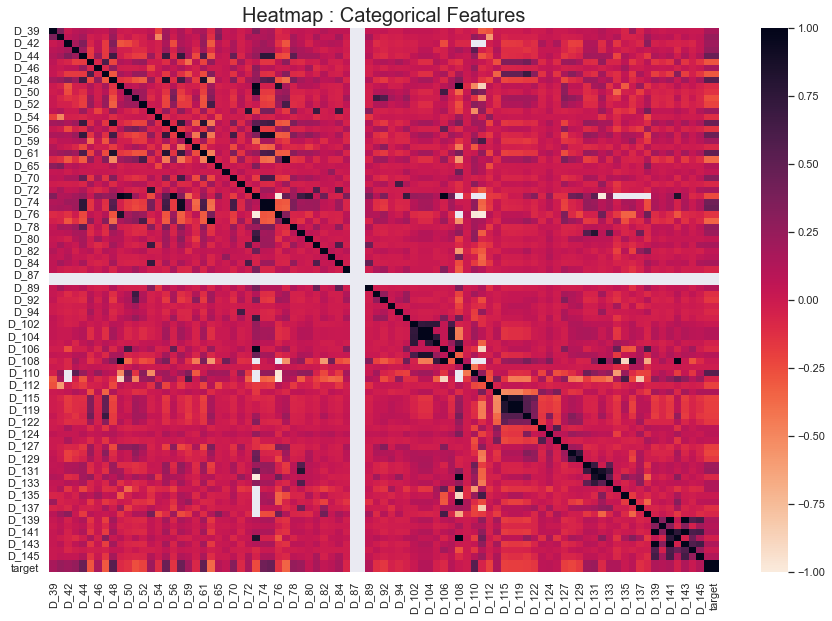

In [27]:
# Target vs Numerical Features
plt.figure(figsize = (15,10))

D_numeric_list.append('target')

cmap = sns.color_palette("rocket_r", as_cmap=True)
sns.heatmap(data_random.loc[:, D_numeric_list].corr(), cmap = cmap)

plt.title('Heatmap : Categorical Features', fontdict = {'size': 20})

# remove target feature after visualization
D_numeric_list.remove('target')

plt.show()

## Insights
- D_145 has the most strongest positive correlation to Target followed by 


In [29]:
# D_numeric_list.append('target')
D_numeric_target_corr = data_random.loc[:, D_col_list].corr()
D_numeric_target_corr['target']

KeyError: 'target'

In [38]:
D_numeric_target_corr[D_numeric_target_corr['target'] > 0.5].index

Index(['D_48', 'D_61', 'D_110', 'target'], dtype='object')

In [54]:
D_numeric_target_corr.loc[abs(D_numeric_target_corr['target']) > 0.3, 'target'].sort_values(ascending = False)

target    1.000000
D_110     0.547607
D_48      0.539116
D_61      0.500658
D_75      0.464314
D_44      0.459882
D_55      0.456625
D_58      0.449936
D_74      0.425503
D_70      0.323648
D_47     -0.301495
D_77     -0.345654
D_62     -0.370977
Name: target, dtype: float64

In [26]:
non_numerical_cols = categorical_cols + date_cols +['customer_ID']

for col in non_numerical_cols:
    columns_list.remove(col)
columns_list.append('target')
columns_list

['P_2',
 'D_39',
 'B_1',
 'B_2',
 'R_1',
 'S_3',
 'D_41',
 'B_3',
 'D_42',
 'D_43',
 'D_44',
 'B_4',
 'D_45',
 'B_5',
 'R_2',
 'D_46',
 'D_47',
 'D_48',
 'D_49',
 'B_6',
 'B_7',
 'B_8',
 'D_50',
 'D_51',
 'B_9',
 'R_3',
 'D_52',
 'P_3',
 'B_10',
 'D_53',
 'S_5',
 'B_11',
 'S_6',
 'D_54',
 'R_4',
 'S_7',
 'B_12',
 'S_8',
 'D_55',
 'D_56',
 'B_13',
 'R_5',
 'D_58',
 'S_9',
 'B_14',
 'D_59',
 'D_60',
 'D_61',
 'B_15',
 'S_11',
 'D_62',
 'D_65',
 'B_16',
 'B_17',
 'B_18',
 'B_19',
 'B_20',
 'S_12',
 'R_6',
 'S_13',
 'B_21',
 'D_69',
 'B_22',
 'D_70',
 'D_71',
 'D_72',
 'S_15',
 'B_23',
 'D_73',
 'P_4',
 'D_74',
 'D_75',
 'D_76',
 'B_24',
 'R_7',
 'D_77',
 'B_25',
 'B_26',
 'D_78',
 'D_79',
 'R_8',
 'R_9',
 'S_16',
 'D_80',
 'R_10',
 'R_11',
 'B_27',
 'D_81',
 'D_82',
 'S_17',
 'R_12',
 'B_28',
 'R_13',
 'D_83',
 'R_14',
 'R_15',
 'D_84',
 'R_16',
 'B_29',
 'S_18',
 'D_86',
 'D_87',
 'R_17',
 'R_18',
 'D_88',
 'B_31',
 'S_19',
 'R_19',
 'B_32',
 'S_20',
 'R_20',
 'R_21',
 'B_33',
 'D_89',
 

In [ ]:
# numerical_cols = list(set(train.columns.tolist()).difference(categorical_cols + date_cols +['customer_ID']))

In [39]:
# numerical_cols = list(set(train.columns.tolist()) - set(categorical_cols + date_cols +['customer_ID']))
numeric_target_corr = data_random.loc[:,columns_list].corr()
numeric_target_corr['target']

P_2      -0.613841
D_39      0.165121
B_1       0.386662
B_2      -0.481761
R_1       0.372699
            ...   
D_142    -0.032684
D_143     0.139681
D_144     0.009372
D_145     0.117891
target    1.000000
Name: target, Length: 178, dtype: float64

### Skewness & Kurtosis

#### Skewness

#### Kurtosis


https://www.kaggle.com/code/amritvirsinghx/eda-basics-handling-skewed-data/notebook

https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45




skewness : https://www.geeksforgeeks.org/how-to-calculate-skewness-and-kurtosis-in-python/

In [40]:
from scipy.stats import skew, kurtosis

numerical_features_skewness = pd.DataFrame()
skewness = []
kurt = []
for col in D_numeric_list:
    skewness.append(train[col].skew(axis=0, skipna=True))
    kurt.append(train[col].kurtosis(axis=0, skipna=True))

# Set feature name as index
numerical_features_skewness['D_numeric_feature'] = D_numeric_list
numerical_features_skewness['skewness'] = skewness
numerical_features_skewness['kurtosis'] = kurt
numerical_features_skewness

,D_numeric_feature,skewness,kurtosis
0,D_39,3.373667,21.437391
1,D_41,6.588384,69.093376
2,D_42,4.190976,36.653877
3,D_43,5.640077,74.263580
4,D_44,3.053946,13.689565
...,...,...,...
83,D_142,0.458392,0.370391
84,D_143,1.721489,0.963927
85,D_144,4.417777,20.122608
86,D_145,5.539598,41.905132


In [37]:
numerical_features_skewness.describe()

,skewness,kurtosis
count,87.000000,8.700000e+01
mean,31.709062,2.846826e+04
std,130.617290,1.744016e+05
min,-6.781015,-1.976952e+00
25%,1.049720,9.998716e-01
50%,3.053946,2.012261e+01
75%,6.896677,9.070694e+01
max,920.519470,1.520772e+06


In [38]:
D_numerical_features_skewness[(D_numerical_features_skewness['kurtosis']>2) & (D_numerical_features_skewness['kurtosis']<4)]

,D_numeric_feature,skewness,kurtosis
18,D_59,0.910477,3.306963
51,D_105,0.935067,3.801808
57,D_111,-1.971301,2.911871
66,D_124,1.250306,3.604887
79,D_138,1.680709,3.808142


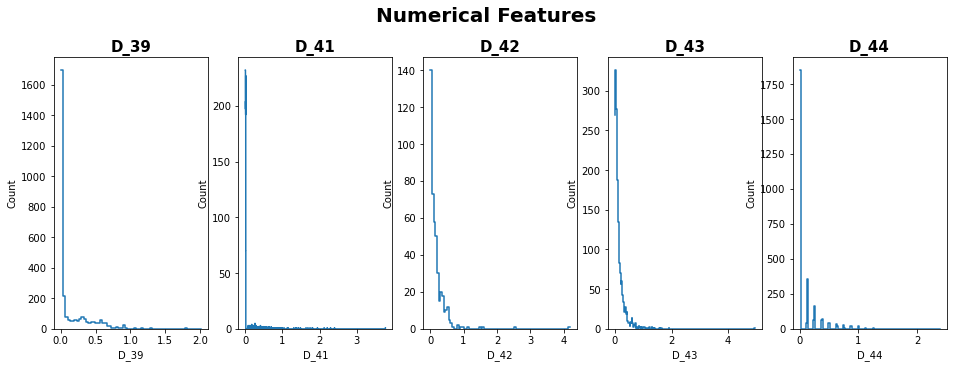

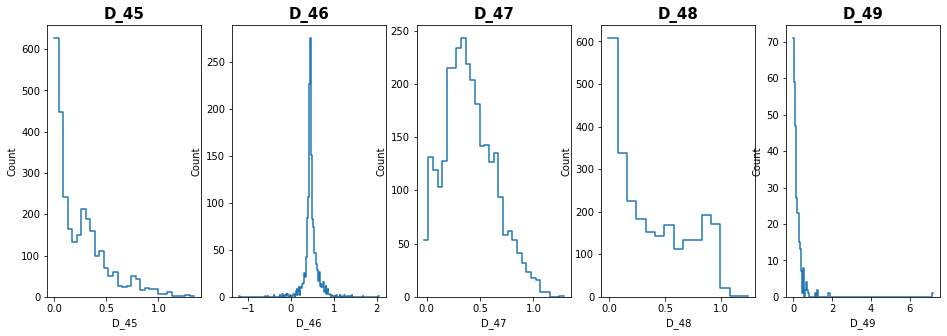

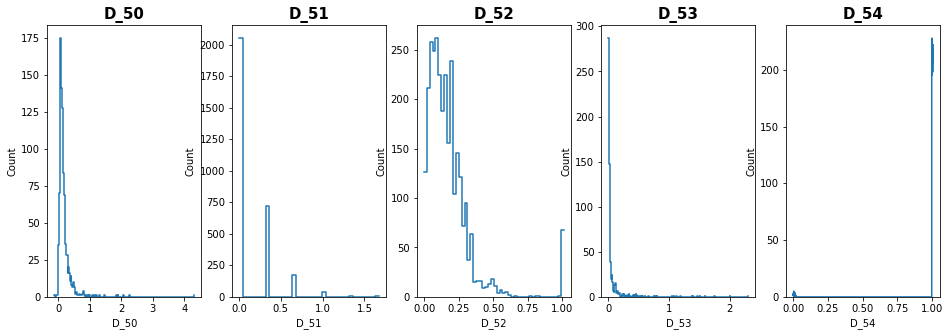

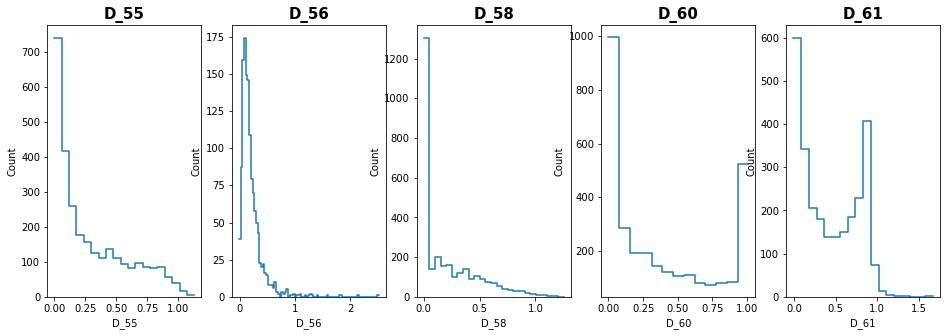

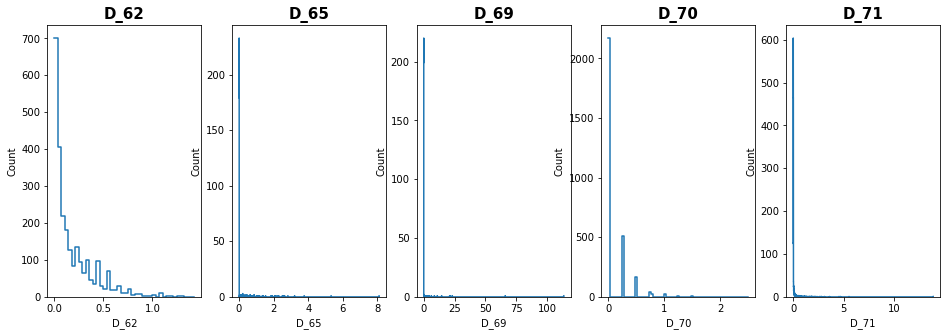

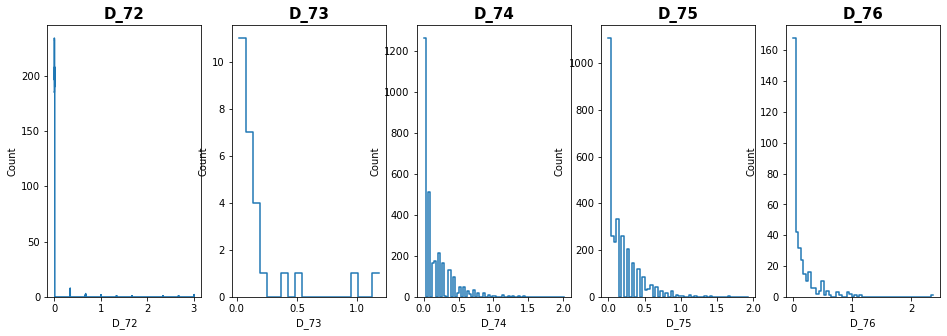

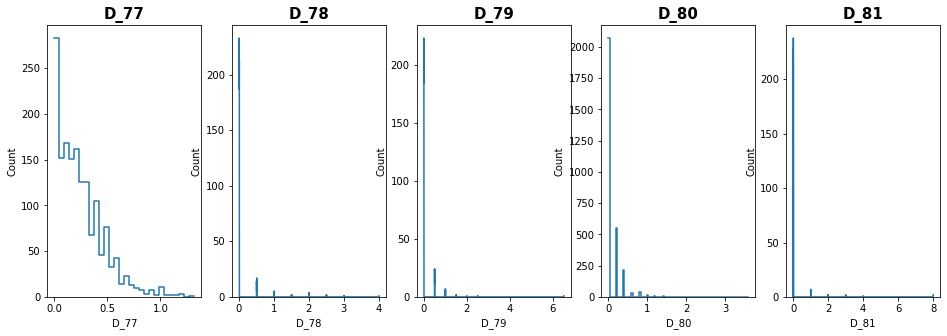

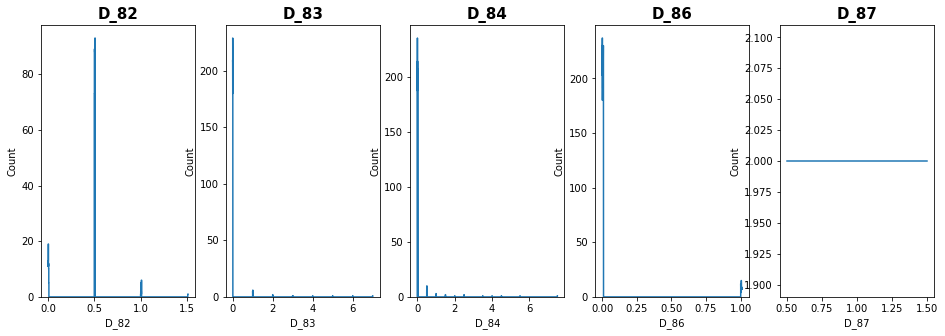

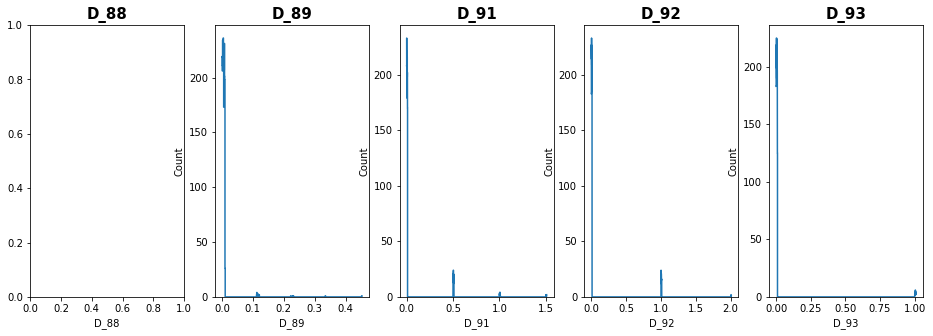

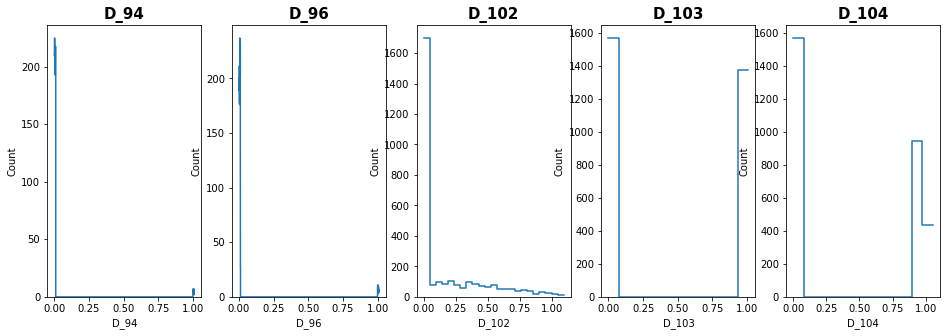

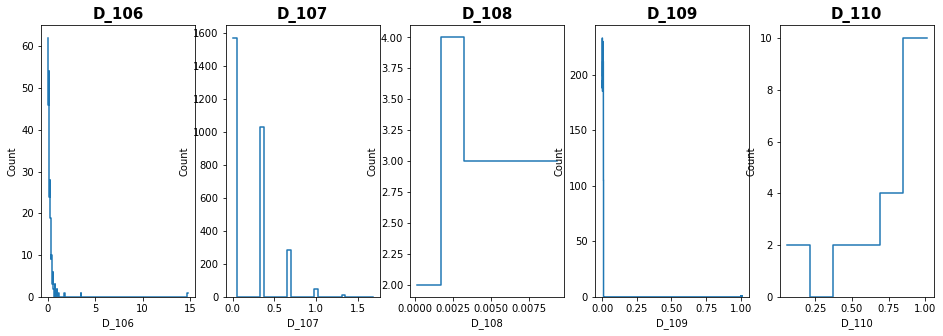

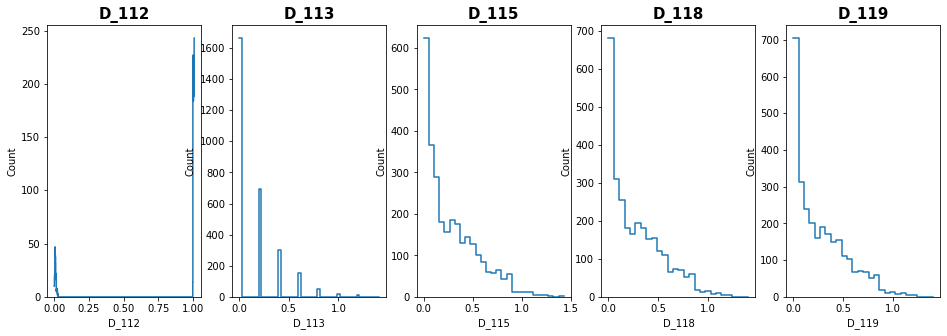

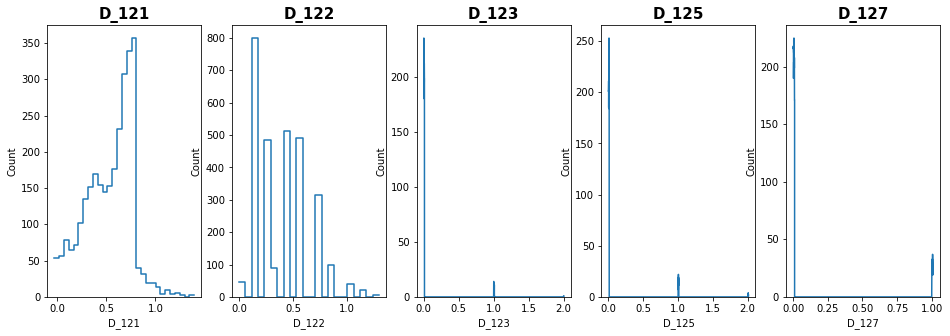

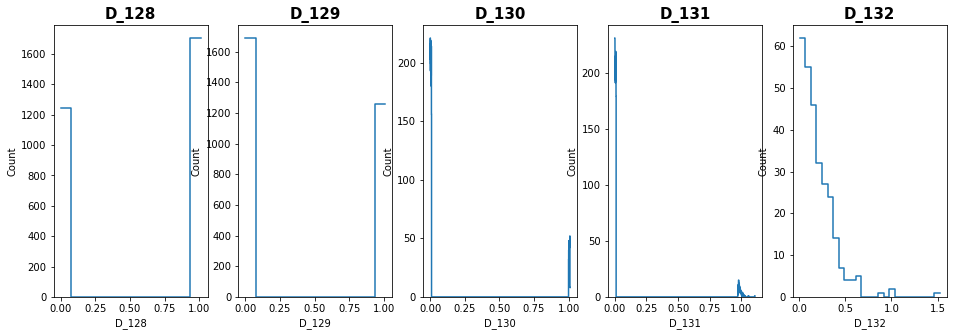

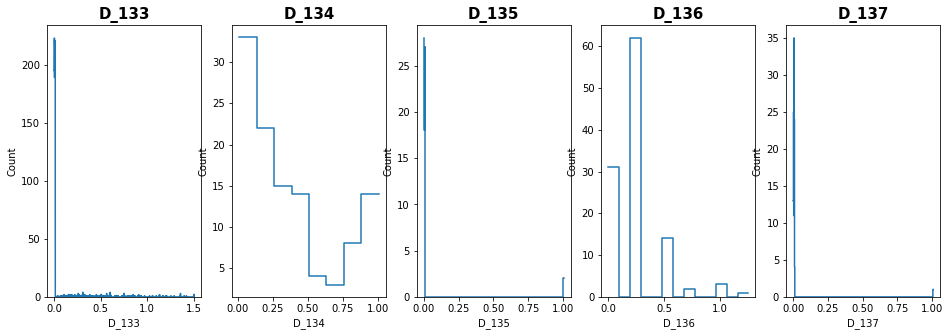

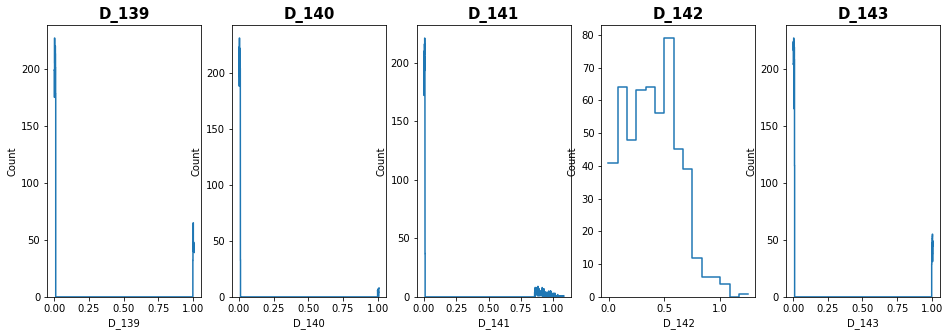

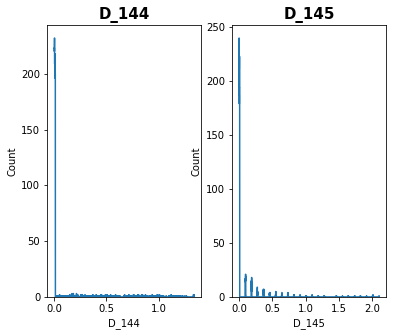

In [33]:


# all feature lists having absolute value of skewness greater than 0.5 & kurtosis less than 3
# condition = (abs(D_numerical_features_skewness['skewness']) < 0.5 ) & (abs(D_numerical_features_skewness['kurtosis']) < 3)
condition = (abs(D_numerical_features_skewness['kurtosis']) < 2) | (abs(D_numerical_features_skewness['kurtosis']) > 4)
normal_D_numeric_features = D_numerical_features_skewness.loc[condition, 'D_numeric_feature'].tolist()

import random
random.seed(10)
rand_index = random.sample(range(train.shape[0]), 3000)
ncols = 5

# Extract a part of dataset for visualization randomly
data_random = train.loc[rand_index, :].reset_index(drop = True)

for i, j in enumerate(normal_D_numeric_features):
    if i % ncols == 0: 
        if i > 0: 
            plt.show()
        plt.figure(figsize=(16, 5))
        if i == 0: 
            plt.suptitle('Numerical Features', fontsize=20, y=1.02, weight = 'bold')
    plt.subplot(1, ncols, i % ncols + 1)
    sns.histplot(data = data_random, x = j, element='step', fill = False) # random index
    plt.title(j, size = 15, weight = 'bold')
    plt.xlabel(j)
plt.show()


In [8]:
train.loc[:,'D_103'].describe()

count    5.429903e+06
mean     4.672621e-01
std      4.985823e-01
min      1.025806e-09
25%      4.645799e-03
50%      9.296491e-03
75%      1.004590e+00
max      1.010000e+00
Name: D_103, dtype: float64

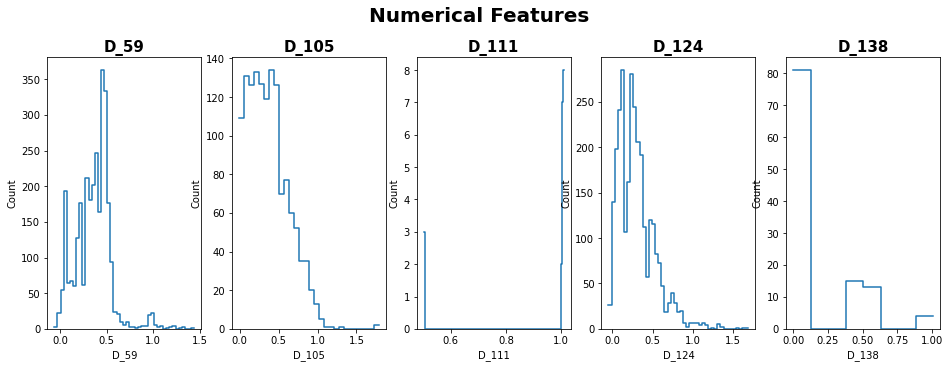

In [39]:
condition = (D_numerical_features_skewness['kurtosis']>2) & (D_numerical_features_skewness['kurtosis']<4)
skewed_D_numeric_features = D_numerical_features_skewness.loc[condition, 'D_numeric_feature'].tolist()

import random
random.seed(10)
rand_index = random.sample(range(train.shape[0]), 3000)
ncols = 5

# Extract a part of dataset for visualization randomly
data_random = train.loc[rand_index, :].reset_index(drop = True)

for i, j in enumerate(skewed_D_numeric_features):
    if i % ncols == 0: 
        if i > 0: 
            plt.show()
        plt.figure(figsize=(16, 5))
        if i == 0: 
            plt.suptitle('Numerical Features', fontsize=20, y=1.02, weight = 'bold')
    plt.subplot(1, ncols, i % ncols + 1)
    sns.histplot(data = data_random, x = j, element='step', fill = False) # random index
    plt.title(j, size = 15, weight = 'bold')
    plt.xlabel(j)
plt.show()

## Box-Cox Transformation

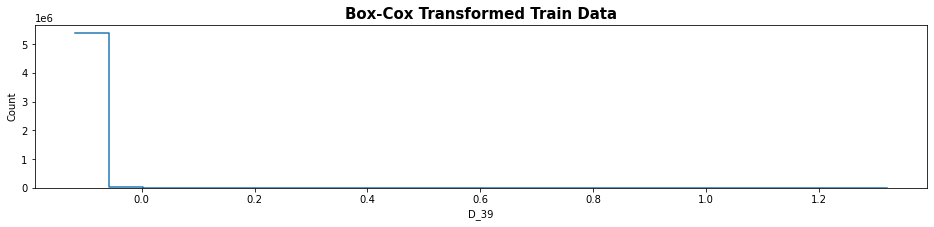

In [47]:
from scipy import stats
boxcox_data, fitted_lambda = stats.boxcox(train['D_144'])
plt.figure(figsize = (16,3))
sns.distplot(data = boxcox_data, element = 'step', fill = False)
plt.title('Box-Cox Transformed Train Data', size = 15 , weight = 'bold')
plt.xlabel('D_39')
plt.show()